In [12]:
from typing import Annotated
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition
from langchain_community.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool
from langgraph.types import Command, interrupt

load_dotenv(override=True)

# Create the Serper search tool
search = GoogleSerperAPIWrapper()
serper_tool = Tool(
    name="Search",
    func=search.run,
    description="Useful for when you need to answer questions about current events or find up-to-date information"
)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools = [serper_tool, human_assistance]

In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# chat bot with tools is the function which will use the llm with tool knowledge
# llm with tools know about the tools and decide if it wants to do a tool call or not
def chat_bot_with_tools(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# tool node is the node which will be used to call the tools
toolNode = ToolNode(tools=tools)

In [14]:
graph_builder.add_node("chat_bot", chat_bot_with_tools)
graph_builder.add_node("tools", toolNode)

graph_builder.add_edge(START, "chat_bot")
graph_builder.add_conditional_edges("chat_bot", tools_condition, "tools")
graph_builder.add_edge("tools", "chat_bot")
graph_builder.add_edge("chat_bot", END)

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

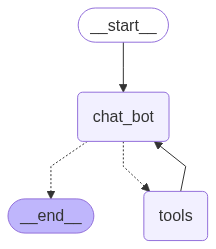

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_nyoBmQI6u62ayvNF1CpWdLY1)
 Call ID: call_nyoBmQI6u62ayvNF1CpWdLY1
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights on the best practices, tools, and frameworks to use?


In [18]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_nyoBmQI6u62ayvNF1CpWdLY1)
 Call ID: call_nyoBmQI6u62ayvNF1CpWdLY1
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights on the best practices, tools, and frameworks to use?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

For building an AI agent, it's recommended to check out **LangGraph**. It is considered more reliable and extensible compared to simple autonomous agents. If you have any specific questions or need further details about using LangGraph or other tools, feel free to ask!
